In [205]:
import pprint
import pandas as pd
import numpy as np
from pmdarima import auto_arima
from arch import arch_model
from statsmodels.tsa.statespace.sarimax import SARIMAX

from matplotlib import pyplot as plt

df_dow = pd.read_csv("../ts_hw_1/Series/weekly-closings-of-the-dowjones-.csv")
df_bstn = pd.read_csv("../ts_hw_1/Series/monthly-boston-armed-robberies-j.csv")
pprint.pp(df_bstn.head())

     Month  Count
0  1966-01     41
1  1966-02     39
2  1966-03     50
3  1966-04     40
4  1966-05     43


In [206]:
ts_dow = df_dow['Close']
ts_bstn = df_bstn['Count']

df_dow['Week'] = df_dow['Week'] + '-1'
ts_dow.index = pd.to_datetime(df_dow['Week'], format='%G-W%V-%u')

ts_bstn.index = pd.to_datetime(df_bstn['Month'])

pprint.pp(ts_bstn.head())

Month
1966-01-01    41
1966-02-01    39
1966-03-01    50
1966-04-01    40
1966-05-01    43
Name: Count, dtype: int64


In [207]:
def garch_forecast(time_series, seasonal=True, m=12, steps=12, freq='w', log_transform=True):
    y = time_series.copy()

    if log_transform:
        y = np.log(y)

    model_auto = auto_arima(
        y,
        seasonal=seasonal,
        m=m,
        freq=freq,
        stepwise=True,
        suppress_warnings=True,
        error_action="ignore",
        trace=True,
        with_intercept=True,
    )

    sarima_model = SARIMAX(
        y,
        order=model_auto.order,
        seasonal_order=model_auto.seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    fit_model = sarima_model.fit(disp=False)

    forecast_obj = fit_model.get_forecast(steps=steps)
    fcst_mean = forecast_obj.predicted_mean
    fcst_ci = forecast_obj.conf_int()

    if log_transform:
        fcst_mean = np.exp(fcst_mean)
        fcst_ci = np.exp(fcst_ci)

    residuals = fit_model.resid

    garch = arch_model(residuals, vol='GARCH', p=1, q=1, dist='normal')
    garch_fitted = garch.fit(disp='off')

    return fcst_mean, fcst_ci, residuals, fit_model, garch_fitted

In [208]:
# fcst_mean, fcst_ci, residuals, arima_model, garch_model = garch_forecast(ts_dow,seasonal=True,m=52,steps=24,log_transform=True) # for Dow

fcst_mean, fcst_ci, residuals, arima_model, garch_model = garch_forecast(ts_bstn,seasonal=True,m=12,steps=12, freq='m',log_transform=True) # for boston
pprint.pprint(fcst_mean)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=-47.234, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-33.454, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-39.510, Time=0.06 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-44.844, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-34.347, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=-45.810, Time=0.09 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=-45.853, Time=0.20 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=-45.333, Time=0.62 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=-44.849, Time=0.59 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=-45.747, Time=0.03 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=-43.788, Time=0.51 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=-43.926, Time=0.30 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=inf, Time=0.69 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=-50.001, Time=0.18 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   

/Users/eugene_ivanov/PycharmProjects/ds_python/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/eugene_ivanov/PycharmProjects/ds_python/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


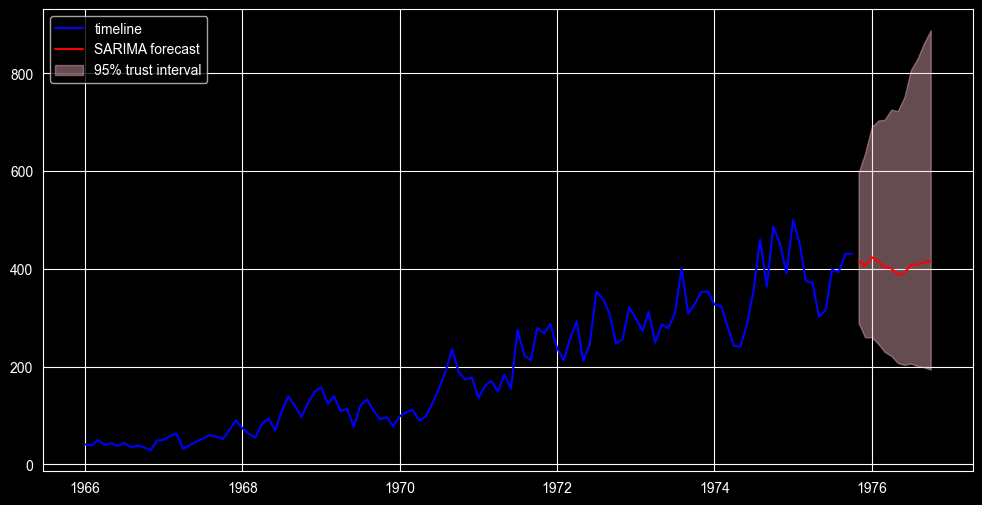

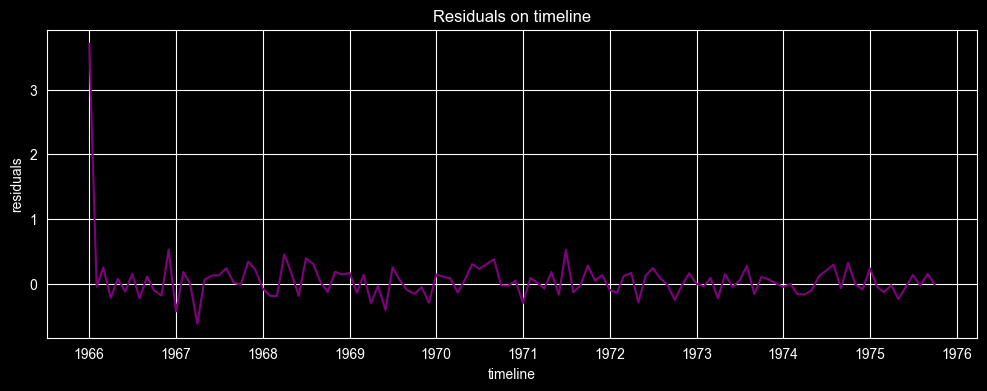

In [209]:
plt.figure(figsize=(12, 6))
plt.plot(ts_bstn.index, ts_bstn, label='timeline', color='blue')
plt.plot(fcst_mean.index, fcst_mean, label='SARIMA forecast', color='red')
plt.fill_between(
    fcst_ci.index,
    fcst_ci.iloc[:, 0],
    fcst_ci.iloc[:, 1],
    color='pink', alpha=0.4, label='95% trust interval'
)
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(residuals.index, residuals, color='purple')
plt.title('Residuals on timeline')
plt.xlabel('timeline')
plt.ylabel('residuals')
plt.grid(True)
plt.show()

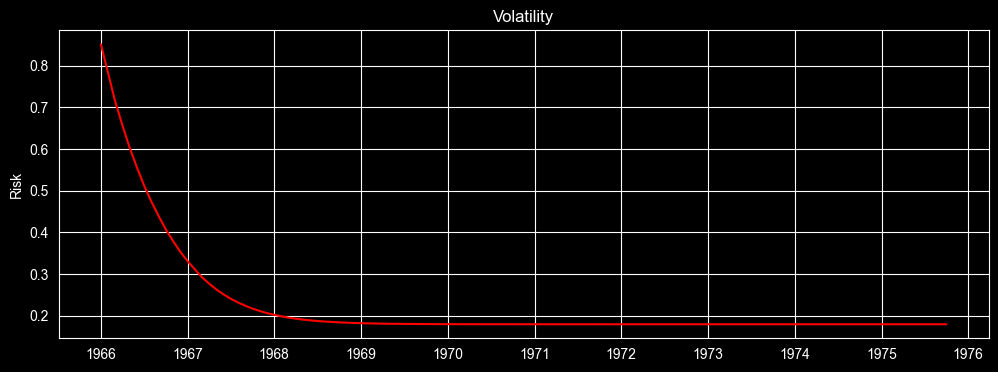

In [210]:
conditional_volatility = garch_model.conditional_volatility

plt.figure(figsize=(12, 4))
plt.plot(conditional_volatility, color='red')
plt.title('Volatility')
plt.ylabel('Risk')
plt.grid(True)
plt.show()